
PROCESSING STIMULUS: tail
✅ Saved plot to: results\figures\ZScore_Violin_tail.png


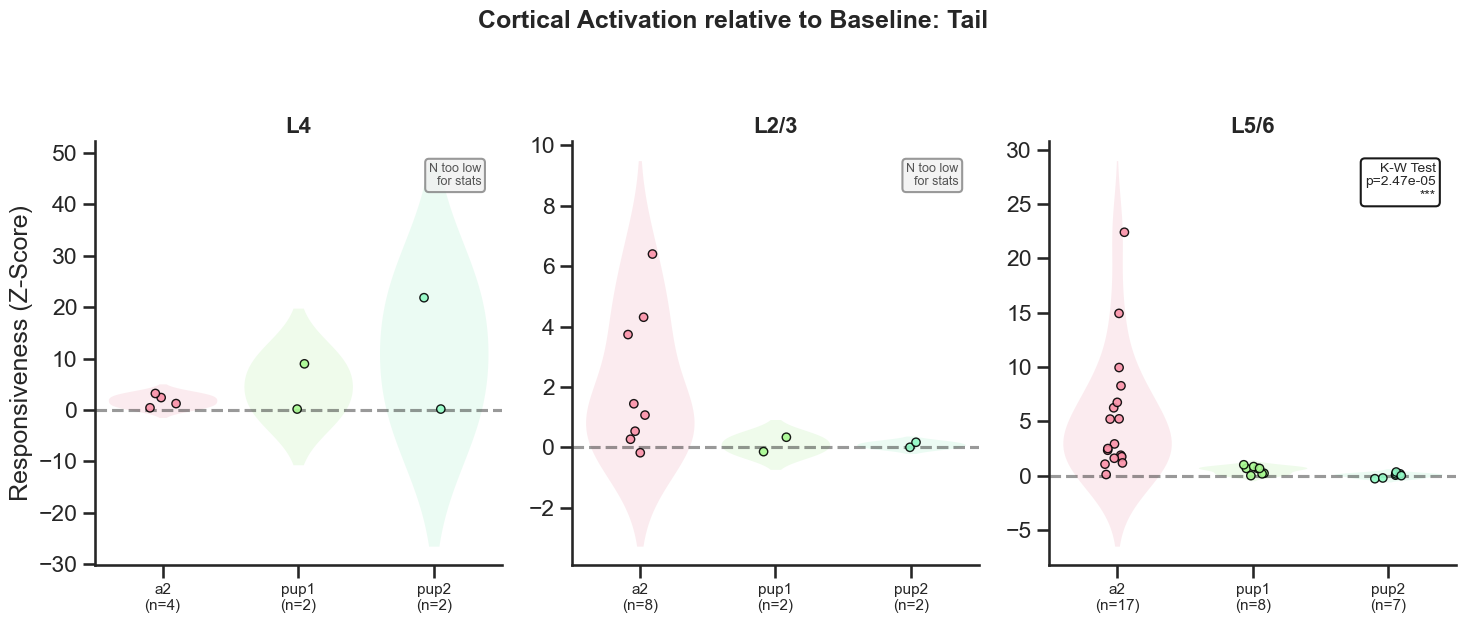


PROCESSING STIMULUS: contra
✅ Saved plot to: results\figures\ZScore_Violin_contra.png


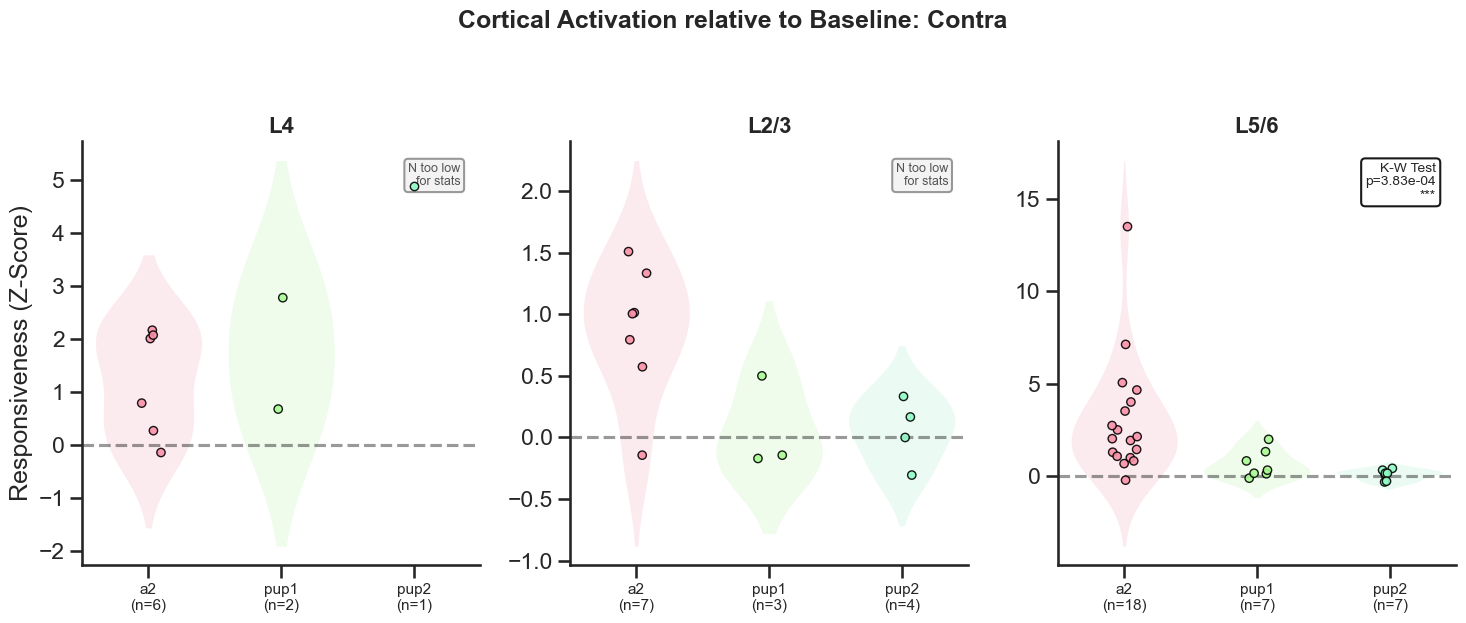


PROCESSING STIMULUS: ipsi
✅ Saved plot to: results\figures\ZScore_Violin_ipsi.png


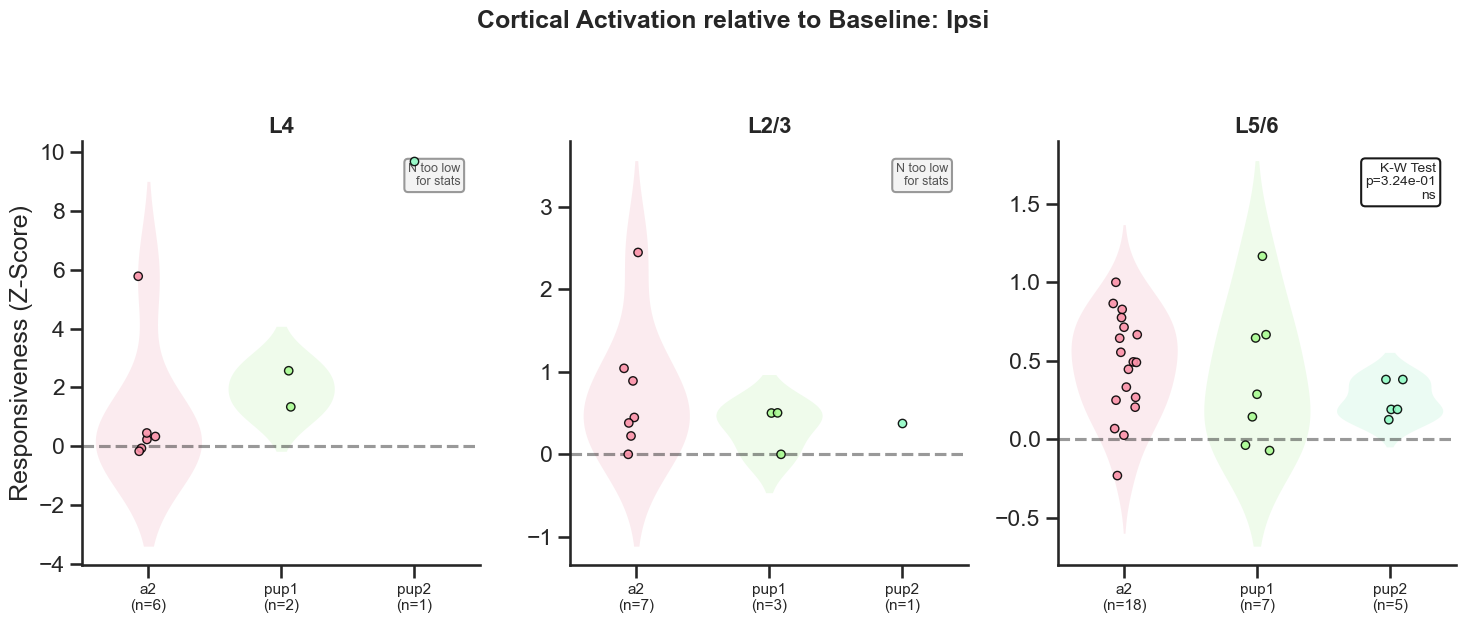

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path
from scipy import stats

# =========================================================
# 1. CONFIGURATION
# =========================================================
# We will loop through these to generate 3 separate plots
STIM_TYPES = ["tail", "contra", "ipsi"] 

# WINDOW SETTINGS
# We use the 1.5s post-window to capture the slow pup response
PRE_WINDOW = 0.5    
POST_WINDOW = 1.5   
EPSILON = 0.5       

# AESTHETICS
ANIMAL_COLORS = {
    "a2":   "#FA91A8",  # Pink
    "pup1": "#A8FA91",  # Green
    "pup2": "#91FAC5"   # Mint
}

# =========================================================
# 2. MAIN PROCESSING LOOP
# =========================================================
csv_path = Path("data/sessions_local.csv") if Path("data/sessions_local.csv").exists() else Path("data/sessions.csv")
meta = pd.read_csv(csv_path)

save_dir = Path("results/figures")
save_dir.mkdir(parents=True, exist_ok=True)

for current_stim in STIM_TYPES:
    
    print(f"\n{'='*60}")
    print(f"PROCESSING STIMULUS: {current_stim}")
    print(f"{'='*60}")
    
    # Define Targets for this specific stimulus
    TARGETS = [
        ("a2",   f"brush_{current_stim}"),  
        ("pup1", f"brush_{current_stim}"),
        ("pup2", f"brush_{current_stim}") 
    ]
    
    z_data = []

    # --- DATA EXTRACTION ---
    for session, stim_name in TARGETS:
        row = meta.loc[(meta['session'] == session) & (meta['stim'] == stim_name)]
        if len(row) == 0: 
            print(f"  > Skipping {session} (No data for {stim_name})")
            continue
        row = row.iloc[0]
        
        onsets_path = Path(f"results/summaries/{session}_{stim_name}_onsets.txt")
        if not onsets_path.exists(): continue
        onsets = np.loadtxt(onsets_path)
        if onsets.ndim == 0: onsets = [onsets]
        
        phy_dir = Path(row['phy_dir'])
        if not (phy_dir / 'spike_times.npy').exists(): continue
        
        spike_times = np.load(phy_dir / 'spike_times.npy').flatten() / 30000.0
        spike_clusters = np.load(phy_dir / 'spike_clusters.npy').flatten()
        cluster_info = pd.read_csv(phy_dir / 'cluster_info.tsv', sep='\t')
        
        lbl = 'KSLabel' if 'KSLabel' in cluster_info.columns else 'group'
        valid_units = cluster_info[cluster_info[lbl].isin(['good', 'mua'])]
        
        # Layer Boundaries
        def get_bound(col): return float(row[col]) if col in row and not pd.isna(row[col]) else None
        l1_bot  = get_bound('l1_end')
        l23_bot = get_bound('l23_end')
        l4_bot  = get_bound('l4_end')
        l6_bot  = get_bound('l6_end')
        if l1_bot is None: l1_bot = get_bound('s1_upper_um')

        for _, unit in valid_units.iterrows():
            uid = unit['cluster_id']
            depth = unit['depth']
            
            layer = "Other"
            if l23_bot is not None and l1_bot is not None and l23_bot <= depth <= l1_bot: layer = "L2/3"
            if l4_bot is not None and l23_bot is not None and l4_bot <= depth < l23_bot: layer = "L4"
            if l6_bot is not None and l4_bot is not None and l6_bot <= depth < l4_bot: layer = "L5/6"

            if layer not in ['L4', 'L2/3', 'L5/6']: continue
            
            u_spikes = spike_times[spike_clusters == uid]
            
            # Calculate Mean Rates per Trial to get Z-Score
            pre_rates = []
            post_rates = []
            
            for t in onsets:
                c_pre = np.sum((u_spikes >= t - PRE_WINDOW) & (u_spikes < t))
                c_post = np.sum((u_spikes >= t) & (u_spikes < t + POST_WINDOW))
                pre_rates.append(c_pre / PRE_WINDOW)
                post_rates.append(c_post / POST_WINDOW)
                
            mu_pre = np.mean(pre_rates)
            std_pre = np.std(pre_rates)
            mu_post = np.mean(post_rates)
            
            # Z-Score Formula
            z = (mu_post - mu_pre) / (std_pre + EPSILON)
            z_data.append({'Animal': session, 'Layer': layer, 'Z': z})

    # --- PLOTTING ---
    if len(z_data) == 0:
        print(f"❌ No units found for {current_stim}.")
        continue

    df = pd.DataFrame(z_data)
    
    # Create Figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=False) 
    layers = ['L4', 'L2/3', 'L5/6']
    
    sns.set_style("ticks")
    sns.set_context("talk") 

    for i, layer in enumerate(layers):
        ax = axes[i]
        subset = df[df['Layer'] == layer]
        
        if len(subset) == 0:
            ax.set_title(layer)
            ax.axis('off')
            continue

        # 1. DYNAMIC LABELS (Add N counts)
        counts = subset['Animal'].value_counts()
        animals_present = ['a2', 'pup1', 'pup2']
        new_labels = []
        
        # Prepare Data Groups for Stats
        groups = []
        valid_animals_for_stats = []
        
        for animal in animals_present:
            n = counts.get(animal, 0)
            new_labels.append(f"{animal}\n(n={n})")
            
            # Extract data for this animal
            animal_z = subset[subset['Animal'] == animal]['Z'].values
            if len(animal_z) > 0:
                groups.append(animal_z)
                valid_animals_for_stats.append(animal)

        # 2. CONDITIONAL STATS
        # Only run if we have at least 2 groups AND at least 5 neurons in the smallest group
        min_n = min([len(g) for g in groups]) if groups else 0
        
        if len(groups) >= 2 and min_n >= 5:
            try:
                stat, p_val = stats.kruskal(*groups)
                sig_text = "ns"
                if p_val < 0.001: sig_text = "***"
                elif p_val < 0.01: sig_text = "**"
                elif p_val < 0.05: sig_text = "*"
                
                # Add Stats Box
                ax.text(0.95, 0.95, f"K-W Test\np={p_val:.2e}\n{sig_text}", 
                        transform=ax.transAxes, ha='right', va='top', 
                        bbox=dict(boxstyle="round", fc="white", ec="black", alpha=0.9),
                        fontsize=10)
            except ValueError:
                pass # Skip if stats fail
        else:
            # Add "Low N" Warning
            ax.text(0.95, 0.95, "N too low\nfor stats", 
                    transform=ax.transAxes, ha='right', va='top', 
                    bbox=dict(boxstyle="round", fc="#f0f0f0", ec="gray", alpha=0.8),
                    fontsize=9, color='#555555')

        # 3. DRAW PLOTS
        # Violin (Background distribution)
        sns.violinplot(data=subset, x="Animal", y="Z", hue="Animal",
                       order=['a2', 'pup1', 'pup2'],
                       palette=ANIMAL_COLORS,
                       inner=None, density_norm='width', linewidth=0, ax=ax, alpha=0.2, legend=False)
        
        # Strip (Individual Data Points - Critical for Low N)
        sns.stripplot(data=subset, x="Animal", y="Z", hue="Animal",
                      order=['a2', 'pup1', 'pup2'],
                      palette=ANIMAL_COLORS,
                      size=6, alpha=0.9, jitter=True, ax=ax, legend=False,
                      edgecolor='black', linewidth=1)

        # 4. FORMATTING
        ax.set_title(f"{layer}", fontweight='bold', fontsize=16)
        ax.set_ylabel("Responsiveness (Z-Score)" if i==0 else "")
        ax.set_xlabel("")
        ax.set_xticks(range(3)) # Ensure 3 ticks for 3 animals
        ax.set_xticklabels(new_labels, fontsize=11) 
        ax.axhline(0, color='black', linestyle='--', alpha=0.4) 
        sns.despine(ax=ax)

    fig.suptitle(f"Cortical Activation relative to Baseline: {current_stim.capitalize()}", 
                 fontsize=18, fontweight='bold', y=1.05)
    
    plt.tight_layout()
    
    # SAVE
    out_file = save_dir / f"ZScore_Violin_{current_stim}.png"
    plt.savefig(out_file, bbox_inches='tight', dpi=300)
    print(f"✅ Saved plot to: {out_file}")
    plt.show()